In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
docs_titles = pd.read_table('docs_titles.tsv')
train_groups = pd.read_csv('train_groups.csv')

data = pd.merge(train_groups, docs_titles, how='left', on='doc_id')[['group_id', 'title', 'target']]

def transform_data(data):
    pattern = r"[^\w\d' ']"
    data['title'] = np.asarray([re.sub(pattern, " ", str(title).lower()) for title in data['title']])

In [5]:
transform_data(data)

In [6]:
data.to_csv("docs_titles.csv")

In [7]:
def get_features(data):
    onehot_groupid = np.zeros((len(data), max(data['group_id'])))
    for i, group_id in enumerate(data['group_id']):
        onehot_groupid[i, group_id - 1] = 1
    max_features = 20
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = np.zeros((1, max_features))
    for _, group in data.groupby('group_id'):
        titles_tfidf = vectorizer.fit_transform(np.asarray(group['title'])).toarray()
        X = np.concatenate((X, titles_tfidf))
    return X[1:]

transform_data(data)

scaler = StandardScaler()
X = get_features(data)
# X = scaler.fit_transform(X)
y = np.asarray(data['target'])

from collections import defaultdict

gkf = GroupKFold(n_splits=5)
scores = []
for train, test, in gkf.split(X, y, groups=data['group_id']):
    clf = LogisticRegression(C=1)
    clf.fit(X[train], y[train])
    prediction = clf.predict(X[test])
    scores.append(f1_score(y[test], prediction))

scores

[0.5318181818181819,
 0.5,
 0.5821868211440985,
 0.5772432932469935,
 0.6046204620462047]

In [8]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [9]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [17]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        all_dist = np.asarray(all_dist)
        X_train.append(sorted(all_dist, reverse=True)[0:5])
X = np.array(X_train)
y = np.array(y_train)
groups_train = np.array(groups_train)

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
rclf = RandomForestClassifier()
gkf = GroupKFold(n_splits=5)
scores = []
for train, test, in gkf.split(X, y, groups=groups_train):
    rclf = RandomForestClassifier()
    rclf.fit(X[train], y[train])
    prediction = rclf.predict(X[test])
    scores.append(f1_score(y[test], prediction))

In [16]:
scores

[0.4789053591790194,
 0.42917547568710357,
 0.5498533724340177,
 0.5661116552399609,
 0.6141834743005856]

In [14]:
X = np.concatenate((X, X**2, X**3, X**4), axis=1)

In [203]:
X[0]

array([0.28851817, 0.64985075, 0.34754853, 0.48147109, 0.59175091,
       0.08324273, 0.422306  , 0.12078998, 0.23181441, 0.35016914,
       0.02401704, 0.27443587, 0.04198038, 0.11161194, 0.2072129 ,
       0.00692935, 0.17834236, 0.01459022, 0.05373792, 0.12261842])

In [24]:
gkf = GroupKFold(n_splits=5)
scores = []
for train, test, in gkf.split(X, y, groups=groups_train):
    clf = svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
    clf.fit(X[train], y[train])
    prediction = clf.predict(X[test])
    scores.append(f1_score(y[test], prediction))

In [25]:
scores

[0.5189003436426116,
 0.49663299663299665,
 0.6794648051192553,
 0.6408045977011495,
 0.7043701799485861]

In [213]:
clf = LogisticRegression(C=1, max_iter=1000, tol=1e-8)
clf.fit(X, y)
prediction = clf.predict(X)
scores.append(f1_score(y, prediction))

In [215]:
def plot_decision_boundary(weights, X, first_feature=0, second_feature=1):
    # Your code Here
    x_points = np.linspace(np.min(X[:, first_feature]),
                           np.max(X[:, first_feature]), 50)
    y_points = -(weights[first_feature] * x_points  +
                 weights[first_feature + 5] * x_points**2  +
                 weights[first_feature + 10] * x_points**3 +
                 weights[first_feature + 10] * x_points**4) / weights[second_feature]
    mask = (y_points < max(X[:, second_feature])) & (
        y_points > min(X[:, second_feature]))
    plt.plot(x_points[mask], y_points[mask])

In [19]:
svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
cross_val_score(svm, X, y, groups=groups_train, cv=5)

array([0.73182207, 0.77159966, 0.77887083, 0.72412318, 0.79726262])

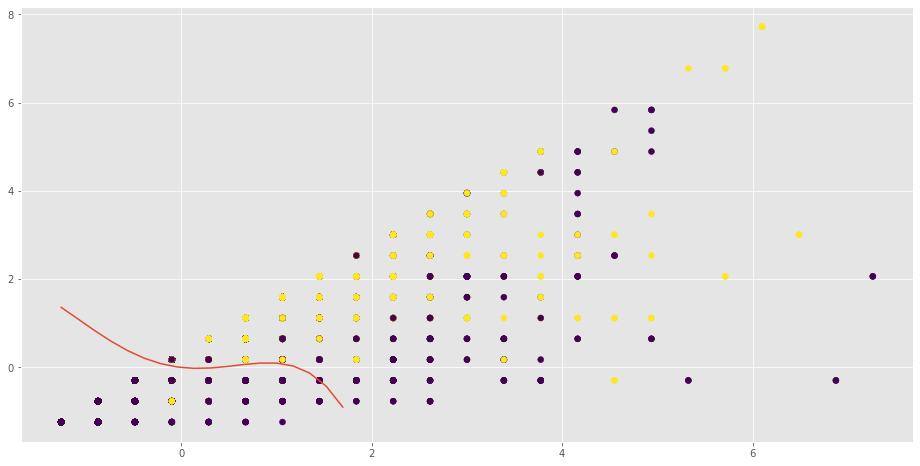

In [216]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_decision_boundary(clf.coef_[0], X, 0, 1)

In [130]:
log_reg_clf.coef_[0]

array([ 1.52674449, -1.76306081])

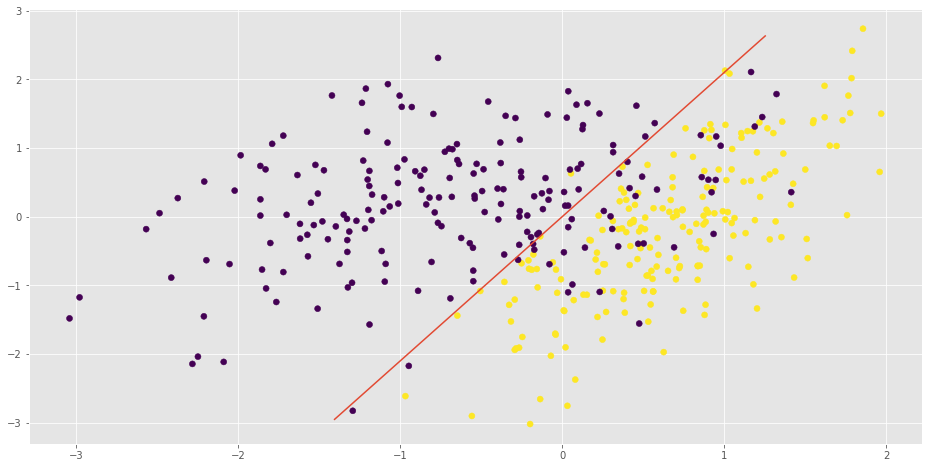

In [137]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

scaler = StandardScaler()
X = scaler.fit_transform(X)

log_reg_clf = LogisticRegression(C=0.1)
log_reg_clf.fit(X, y)
plot_decision_boundary(log_reg_clf.coef_[0], X)

plt.scatter(X[:, 0], X[:, 1], c=y)